In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from matplotlib import pyplot as plt
import seaborn as sn
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from fpdf import FPDF
import pickle
from datetime import datetime

pdf = FPDF()
pdf_reports = dict()

In [2]:
dataset = pd.read_csv('data/dataset.csv', index_col=0)
# dataset = dataset.drop(columns=["index_x", "index_y", "index_x.1", "index_y.1", 'index'])

dataset.head()

,date,symbol,econ_branch,score,year,month,day,close,roi_month,roi_quarter,roi_halfyear,roi_year
0,2004-02-11,SU,Energy Minerals,0.953727,2004,2,11,13.285000,0.015807,-0.085058,0.048927,0.406473
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,2,11,9.388889,-0.048047,-0.010888,0.087811,0.348402
2,2004-02-11,CWT,Utilities,0.934181,2004,2,11,14.720000,-0.002717,-0.068954,-0.070992,0.178668
3,2004-02-11,BLL,Process Industries,0.922862,2004,2,11,8.095000,0.006640,-0.023935,0.124923,0.361334
4,2004-02-11,APA,Energy Minerals,0.912117,2004,2,11,39.830002,0.008034,0.025860,0.082350,0.442882


<AxesSubplot:>

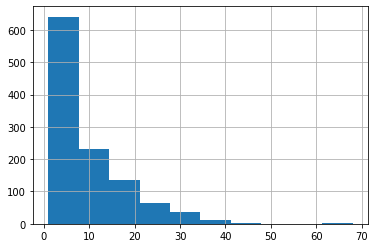

In [3]:
dataset.symbol.value_counts().hist()

As shown in the histogram, most of the symbols appear in the dataset only once, so there is no point considering each symbol as a separate time series.

<AxesSubplot:>

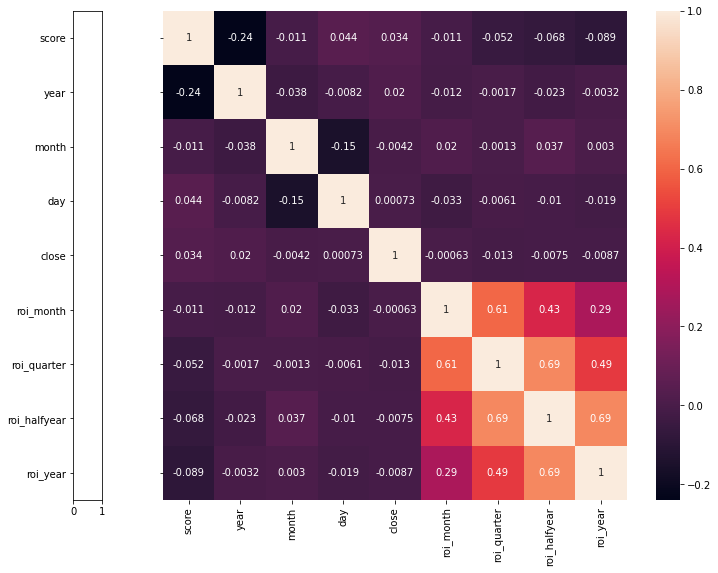

In [4]:

fig, ax = plt.subplots(1,2, figsize=(12, 9), sharey=True, gridspec_kw={'width_ratios': [1, 20]})
sn.heatmap(dataset.corr(), annot=True)

The heatmap of correlations shows, that roi values aren't linearly correlated with any variable in our dataset.

In [5]:
X = dataset[['score', 'close', 'year', 'econ_branch']]
y = dataset.iloc[:, -4:]

In [6]:
dummies = pd.get_dummies(X[['econ_branch']], drop_first=True)
X = pd.concat([X.drop(['econ_branch'],axis=1), dummies],axis=1)
X

,score,close,year,econ_branch_Communications,econ_branch_Consumer Durables,econ_branch_Consumer Non-Durables,econ_branch_Consumer Services,econ_branch_Distribution Services,econ_branch_Electronic Technology,econ_branch_Energy Minerals,...,econ_branch_Health Services,econ_branch_Health Technology,econ_branch_Industrial Services,econ_branch_Non-Energy Minerals,econ_branch_Process Industries,econ_branch_Producer Manufacturing,econ_branch_Retail Trade,econ_branch_Technology Services,econ_branch_Transportation,econ_branch_Utilities
0,0.953727,13.285000,2004,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.952753,9.388889,2004,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.934181,14.720000,2004,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.922862,8.095000,2004,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.912117,39.830002,2004,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,0.657795,90.209999,2021,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10406,0.651998,1423.270020,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10407,0.650983,193.690002,2021,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10408,0.646593,53.529999,2021,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We've chosen 4 variables as input for the models.
* score - the conviction score
* close - the closing price
* year - the year of the data point
* econ_branch - the name of the branch of the company. this variable is split into 18 binary dummy variables.

We split the data into train and test with proportions 0.67 - 0.33

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
def calculate_errors_for_train_test_split(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame): # y_train and y_test should be only one column
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors_report = ["1. Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)]
    errors_report.append("2. Mean absolute percentage error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))
    errors_report.append("3. R^2: %.2f" % r2_score(y_test, y_pred))
    print(errors_report)
    return errors_report

In [13]:
def calculate_errors_for_cross_validation(model, X: pd.DataFrame, y: pd.DataFrame): # y should be only one column
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    mae = abs(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)).mean()
    mape = abs(cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)).mean()
    r2 = abs(cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)).mean()
    errors_report = ["1. Mean squared error: %.2f" % mae]
    errors_report.append("2. Mean absolute percentage error: %.2f" % mape)
    errors_report.append("3. R^2: %.2f" % r2)
    print(errors_report)
    return errors_report

In [14]:
y

,roi_month,roi_quarter,roi_halfyear,roi_year
0,0.015807,-0.085058,0.048927,0.406473
1,-0.048047,-0.010888,0.087811,0.348402
2,-0.002717,-0.068954,-0.070992,0.178668
3,0.006640,-0.023935,0.124923,0.361334
4,0.008034,0.025860,0.082350,0.442882
...,...,...,...,...
10405,0.080479,0.007538,-0.115397,-0.042013
10406,0.058970,0.088543,0.183001,0.514533
10407,-0.049099,-0.008725,-0.146420,-0.409830
10408,0.153185,0.029516,-0.109658,-0.248085


In [11]:
pdf = FPDF()

In [17]:
for roi in ['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year']:
    pdf_reports[roi] = {}

    dummy_regr = DummyRegressor(strategy="mean")
    pdf_reports[roi]['dummy_train_test'] = calculate_errors_for_train_test_split(dummy_regr, X_train, X_test, y_train[roi].to_frame(), y_test[roi].to_frame())

    dummy_regr = DummyRegressor(strategy="mean")
    pdf_reports[roi]['dummy_cross_validate'] = calculate_errors_for_cross_validation(dummy_regr, X, y[roi].to_frame())

    lin_regr = LinearRegression()
    pdf_reports[roi]['lin_regr_train_test'] = calculate_errors_for_train_test_split(lin_regr, X_train, X_test, y_train[roi].to_frame(), y_test[roi].to_frame())

    lin_regr = LinearRegression()
    pdf_reports[roi]['lin_regr_cross_validate'] = calculate_errors_for_cross_validation(lin_regr, X, y[roi].to_frame())

['1. Mean squared error: 0.01', '2. Mean absolute percentage error: 246363940402.32', '3. R^2: -0.00']
['1. Mean squared error: 0.06', '2. Mean absolute percentage error: 279477149765.40', '3. R^2: 0.00']
['1. Mean squared error: 0.01', '2. Mean absolute percentage error: 235917907372.29', '3. R^2: 0.00']
['1. Mean squared error: 0.06', '2. Mean absolute percentage error: 291491207293.52', '3. R^2: 0.00']
['1. Mean squared error: 0.02', '2. Mean absolute percentage error: 163322025532.92', '3. R^2: -0.00']
['1. Mean squared error: 0.10', '2. Mean absolute percentage error: 253215086857.09', '3. R^2: 0.00']
['1. Mean squared error: 0.02', '2. Mean absolute percentage error: 166503753145.32', '3. R^2: 0.00']
['1. Mean squared error: 0.10', '2. Mean absolute percentage error: 202136145490.01', '3. R^2: 0.01']
['1. Mean squared error: 0.04', '2. Mean absolute percentage error: 442720016741.64', '3. R^2: -0.00']
['1. Mean squared error: 0.15', '2. Mean absolute percentage error: 20689934948

In [18]:
with open('pickled_results/initial_modelling.pickle', 'wb') as f:
    pickle.dump(pdf_reports, f)

In [107]:
for roi in ['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year']:

    dummy_regr = DummyRegressor(strategy="mean")
    pdf_reports['dummy_train_test'] = calculate_errors_for_train_test_split(dummy_regr, X_train, X_test, y_train[roi].to_frame(), y_test[roi].to_frame())

    dummy_regr = DummyRegressor(strategy="mean")
    pdf_reports['dummy_cross_validate'] = calculate_errors_for_cross_validation(dummy_regr, X, y[roi].to_frame())

    lin_regr = LinearRegression()
    pdf_reports['lin_regr_train_test'] = calculate_errors_for_train_test_split(lin_regr, X_train, X_test, y_train[roi].to_frame(), y_test[roi].to_frame())

    lin_regr = LinearRegression()
    pdf_reports['lin_regr_cross_validate'] = calculate_errors_for_cross_validation(lin_regr, X, y[roi].to_frame())

    pdf.add_page()
    pdf.set_font("Arial", size = 15)
    pdf.cell(200, 10, txt = f"Target variable: {roi}", ln = 1, align = 'C')
    
    pdf.set_font("Arial", size = 13)
    pdf.cell(200, 10, txt = "Predictor no. 1 - Dummy Regressor (it's prediction is always the mean of the train set)", ln = 2, align = 'C')
    pdf.set_font("Arial", size = 12)
    pdf.cell(200, 10, txt = "Train-test split (0.67 - 0.33):", ln = 2, align = 'L')
    pdf.set_font("Arial", size = 11)
    for line in pdf_reports['dummy_train_test']:
        pdf.cell(200, 10, txt = '        ' + line, ln = 2, align = 'L')
    pdf.set_font("Arial", size = 12)
    pdf.cell(200, 10, txt = "Cross-validation (split into 10 folds, repeated 3 times):", ln = 2, align = 'L')
    pdf.set_font("Arial", size = 11)
    for line in pdf_reports['dummy_cross_validate']:
        pdf.cell(200, 10, txt = '        ' + line, ln = 2, align = 'L')

    pdf.set_font("Arial", size = 13)
    pdf.cell(200, 10, txt = "Predictor no. 2 - Linear Regression", ln = 2, align = 'C')
    pdf.set_font("Arial", size = 12)
    pdf.cell(200, 10, txt = "Train-test split (0.67 - 0.33):", ln = 2, align = 'L')
    pdf.set_font("Arial", size = 11)
    for line in pdf_reports['lin_regr_train_test']:
        pdf.cell(200, 10, txt = '        ' + line, ln = 2, align = 'L')
    pdf.set_font("Arial", size = 12)
    pdf.cell(200, 10, txt = "Cross-validation (split into 10 folds, repeated 3 times):", ln = 2, align = 'L')
    pdf.set_font("Arial", size = 11)
    for line in pdf_reports['lin_regr_cross_validate']:
        pdf.cell(200, 10, txt = '        ' + line, ln = 2, align = 'L')

['1. Mean squared error: 0.01', '2. Mean absolute percentage error: 246363940402.32', '3. R^2: -0.00']
['1. Mean squared error: 0.06', '2. Mean absolute percentage error: 279477149765.40', '3. R^2: 0.00']
['1. Mean squared error: 0.01', '2. Mean absolute percentage error: 235917907372.29', '3. R^2: 0.00']
['1. Mean squared error: 0.06', '2. Mean absolute percentage error: 291491207293.53', '3. R^2: 0.00']
['1. Mean squared error: 0.02', '2. Mean absolute percentage error: 163322025532.92', '3. R^2: -0.00']
['1. Mean squared error: 0.10', '2. Mean absolute percentage error: 253215086857.09', '3. R^2: 0.00']
['1. Mean squared error: 0.02', '2. Mean absolute percentage error: 166503753145.32', '3. R^2: 0.00']
['1. Mean squared error: 0.10', '2. Mean absolute percentage error: 202136145490.01', '3. R^2: 0.01']
['1. Mean squared error: 0.04', '2. Mean absolute percentage error: 442720016741.64', '3. R^2: -0.00']
['1. Mean squared error: 0.15', '2. Mean absolute percentage error: 20689934948

In [108]:
pdf.output('reports/Errors_report.pdf')   

''

<AxesSubplot:xlabel='score', ylabel='roi_month'>

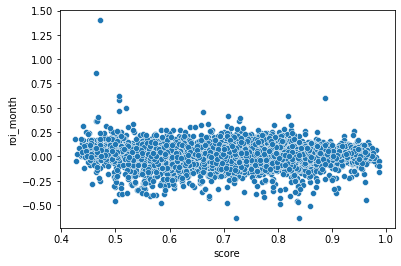

In [54]:
sn.scatterplot(x=X_train.score, y=y_train.roi_month)